# Luttinger Liquid Fit to Inelastic Scattering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mpl_colors

from pimcscripts import pimchelp
from collections import defaultdict
from lmfit import Model, Parameters

import importlib

from dgutils import colors as colortools
import dgutils
import spens

%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'sans':'../include/sans_NC.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])

figsize = plt.rcParams['figure.figsize']

π = np.pi
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import poreutils as pore
importlib.reload(pore)

from poreutils import red,orange,green,lblue,blue,dblue,purple
from poreutils import pore_colors,pore_labels,font_path

## Read in Data for the Luttinger Liquid Fit

In [3]:
class LLfit:
    def __init__(self, filename):
        self.y,self.Δy,self.x, self.Δx = np.loadtxt(filename,unpack=True)
        
def Qkey(Q=4.00,T=1.6):
    return f'Qinc = {Q:4.2f} 1/Å, T = {T:3.1f} K'

In [4]:
Q_inc = [1.71,2.50,4.00]
peaks = {}
for cQ in Q_inc:
    Q_label = f'{cQ:4.2f}'.replace('.','_')
    peaks[Qkey(Q=cQ)] = LLfit(f'../data/fit_parm_{Q_label}.dat')

### Plot the peak data and LL prediction
#### plot_LL_maxima

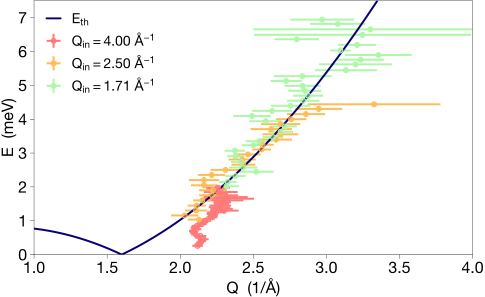

In [5]:
def plot_LL_maxima(_ax,peaks,Q_inc):
    
    ## Plot the data extracted from S(Q,ω)
    col = [red,orange,green]
    for i,cQ in enumerate(Q_inc[::-1]):
        label = r'$Q_{\rm in} = $' + f'{cQ:4.2f} ' +r'$\mathrm{\AA}^{-1}$'
        _ax.errorbar(peaks[Qkey(Q=cQ)].x,peaks[Qkey(Q=cQ)].y,xerr=peaks[Qkey(Q=cQ)].Δx,yerr=peaks[Qkey(Q=cQ)].Δy,
                    **pore.get_props(col[i]), label=label)
        
    # the LL prediction, determined from a separate analysis via DAVE
    KL = 1.22
    kF = 0.8
    _Q = np.linspace(0,5,1000)
    _ax.plot(_Q,pore.ω_LL(-1,_Q,KL,kF), color=purple, label=r'$E_{\rm th}$')
    
    _ax.set_ylim(0.0,7.5)
    _ax.set_xlim(1,4)
    _ax.set_xlabel('Q  (1/Å)')
    _ax.set_ylabel('E  (meV)')
    _ax.legend();

with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_LL_maxima(ax,peaks,Q_inc)

## Dependence on the Incident Wavevector and Temperature

In [6]:
class inelastic_scattering:
    def __init__(self, filename):
        self.Qvals,self.Evals,self.S,self.ΔS = spens.load_file(filename)
        self.E,self.Q = np.meshgrid(self.Evals,self.Qvals)

In [7]:
S = {}

# first get the Q_incidence dependence
cT = 1.6
for cQ in Q_inc:
    S[Qkey(Q=cQ)] = inelastic_scattering(f'../data/SQE_Qinc_{cQ:4.2f}A_T_{cT:3.1f}.spe')

# Now the temperature Dependence
cQ = 4.00
T = [1.6, 2.5, 4.2]
for cT in T:
    S[Qkey(T=cT)] = inelastic_scattering(f'../data/SQE_Qinc_{cQ:4.2f}A_T_{cT:3.1f}.spe')

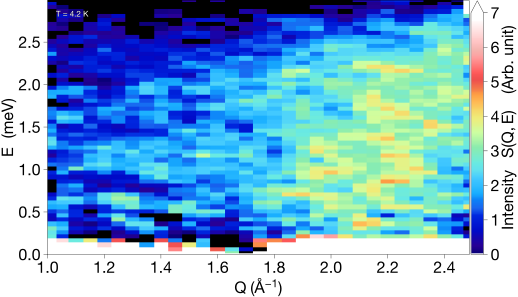

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

def plot_SQE(_ax, _S, vmax=7, label=""):

    palette = pore.get_masked_palette('../include/GMT_haxby.cpt')
    pcm = _ax.pcolormesh(_S.Q,_S.E,_S.S, edgecolor='None', rasterized=True, shading='auto', 
                        norm=mpl_colors.Normalize(vmin=0.0, vmax=vmax),cmap=palette, snap=True)
    
    _ax.set_xlabel(r'$Q \; (\mathrm{\AA}^{-1})$')
    _ax.set_ylabel(r'$E$  (meV)')
    _ax.set_ylim(0,np.max(_S.Evals))
    _ax.set_xlim(1.0,np.max(_S.Qvals))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.025)

    fig.colorbar(pcm, cax=cax, label=r'Intensity $\;\;S(Q,E)\;\;$  (Arb. unit)',  extend='max')
    
    path_eff=[path_effects.withSimplePatchShadow(offset=(0.06, -0.06), shadow_rgbFace='k', alpha=1.0)]
    
    _ax.text(0.02,0.96,label, ha='left',va='top', transform=_ax.transAxes, color='w', fontsize=8, 
            path_effects=path_eff)
    
    return pcm
    
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_SQE(ax,S[Qkey(T=4.2)], label='T = 4.2 K')
    

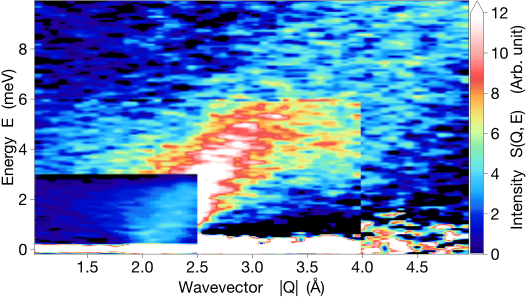

In [9]:
def plot_SQE_autoscale(_ax, _S, vmax=12):

    # setup a masked color pallette
    palette = pore.get_masked_palette('../include/GMT_haxby.cpt')

    for cQ in Q_inc:
        pcm = _ax.imshow(_S[Qkey(cQ)].S.T, extent=(np.min(_S[Qkey(cQ)].Qvals), np.max(_S[Qkey(cQ)].Qvals), np.min(_S[Qkey(cQ)].Evals), np.max(_S[Qkey(cQ)].Evals)), 
                         aspect='auto', origin='lower',norm=mpl_colors.Normalize(vmin=0.0, vmax=vmax),cmap=palette)

    _ax.autoscale()
    
    _ax.set_xlabel(r'Wavevector  $\;\;|Q|\;\;  ( Å )$')
    _ax.set_ylabel(r'Energy  E  (meV)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.025)

    fig.colorbar(pcm, cax=cax, label=r'Intensity $\;\;S(Q,E)\;\;$  (Arb. unit)',  extend='max')

with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_SQE_autoscale(ax,S)

## Make the Combined Figure

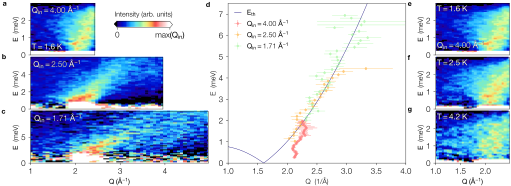

In [31]:

with plt.style.context(plot_style['sans']):
    
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.06, -0.06), shadow_rgbFace='k', alpha=1.0)]

    figsize = plt.rcParams['figure.figsize']
    dgutils.fonts.set_custom_font(font_path)
    fig = plt.figure(figsize=(1.93*1.03*figsize[0],1.16*1.03*figsize[1]), constrained_layout=False)
    left,middle,right = fig.subfigures(nrows=1,ncols=3, width_ratios=[2,2,1])
    ax_middle = middle.subplots(1,1, sharex=True, gridspec_kw={"left":0.05})
# #         "bottom": 0.25,
# #         "top": 0.95,
# #         "left": 0.1,
# #         "right": 0.5,
#           "wspace": 0.3,
#          "hspace": 0.25,
#      },
                               #)
    ax_right = right.subplot_mosaic([[Qkey(T=1.6)],[Qkey(T=2.5)],[Qkey(T=4.2)]], gridspec_kw={"hspace":0.05, "left":0.2})
    mosaic="""AAA.....
              BBBBBB..
              CCCCCCCC"""
    ax_left = left.subplot_mosaic(mosaic, gridspec_kw={"hspace":0.05})
    
    # Maxima Fitting
    plot_LL_maxima(ax_middle,peaks,Q_inc)
    
    # Q-dependence
    cT = 1.6
    vmaxes = [7,32,14]
    ax_labels=['A','B','C']
    p = []
    for i,cQ in enumerate([4.00,2.5,1.71]):
        _p = plot_SQE(ax_left[ax_labels[i]],S[Qkey(Q=cQ)] , vmax=vmaxes[i], label=r'$Q_{\rm in} = $' + f'{cQ:4.2f} ' +r'$\mathrm{\AA}^{-1}$')
        p.append(_p)
        
    ax_left['A'].text(0.02,0.22,f'$T = {cT:3.1f}\; \mathrm{{K}}$', ha='left',va='top', color='w',
                      transform=ax_left['A'].transAxes, fontsize=8, path_effects=path_eff)

        
    # the colorbar
    vmin = 0
    vmax = 7
    palette = pore.get_masked_palette('../include/GMT_haxby.cpt')
    sm = plt.cm.ScalarMappable(cmap=palette, norm=mpl_colors.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    
    loc = 'center right'
    vshift = 0.09
    axins1 = inset_axes(ax_left['A'],
                    width="100%",  
                    height="12%", 
                    loc=loc,
                    bbox_to_anchor=(3.5, vshift, 2.25, 1),
                    bbox_transform=ax_left['A'].transAxes,
                    borderpad=0)
  
    cb = fig.colorbar(sm, cax=axins1, orientation='horizontal', ticks=[0,7], extend='both')
    cb.set_label('Intensity (arb. units)',labelpad=5)
    cb.ax.xaxis.set_label_position('top')
    cb.ax.xaxis.set_tick_params(pad=2)
    cb.ax.set_xticklabels(['0', 'max'+r'$(Q_{\rm in})$'])
        
    # Temperature Dependence
    cQ = 4.00
    for i,cT in enumerate(T):
        plot_SQE(ax_right[Qkey(T=cT)],S[Qkey(T=cT)] , vmax=7, label=f'$T = {cT}\; \mathrm{{K}}$')
        
    label = r'$Q_{\rm in} = $' + f'{cQ:4.2f} ' +r'$\mathrm{\AA}^{-1}$'
    ax_right[Qkey(T=1.6)].text(0.02,0.28,label, ha='left',va='top', transform=ax_right[Qkey(T=1.6)].transAxes, color='w',
                              fontsize=8,path_effects=path_eff)


    # sharing axes
    ax_left['A'].set_xlim(1,2.5)
    ax_left['B'].set_xlim(1,4.0)
    
    ax_left['A'].xaxis.set_visible(False)
    ax_left['B'].xaxis.set_visible(False)
    
    ax_right[Qkey(T=1.6)].xaxis.set_visible(False)
    ax_right[Qkey(T=2.5)].xaxis.set_visible(False)
    
    # panel labels
    font_props = dgutils.fonts.get_custom_font_props(pore.bold_font_path)

    ax_left['A'].text(0.35,3.15,'a', ha='left',va='top', color='k', font=font_props)
    ax_left['B'].text(0.35,6.4,'b', ha='left',va='top',  color='k', font=font_props)
    ax_left['C'].text(0.35,10.5,'c', ha='left',va='top',  color='k', font=font_props)
    ax_middle.text(-0.125,1.01,'d', ha='left',va='top', transform=ax_middle.transAxes, font=font_props)
    ax_right[Qkey(T=1.6)].text(-0.375,1.05,'e', ha='left',va='top', transform=ax_right[Qkey(T=1.6)].transAxes, color='k', font=font_props)
    ax_right[Qkey(T=2.5)].text(-0.375,1.05,'f', ha='left',va='top', transform=ax_right[Qkey(T=2.5)].transAxes, color='k', font=font_props)
    ax_right[Qkey(T=4.2)].text(-0.375,1.1,'g', ha='left',va='top', transform=ax_right[Qkey(T=4.2)].transAxes, color='k', font=font_props)
        
    plt.savefig('../figures/LL_fit_Qinc_T_dep.pdf')
    plt.savefig('../figures/LL_fit_Qinc_T_dep.svg')